<p style="font-size: 18px;">
  This is the accompanying code for the post titled "Decoding AI Decisions: Interpreting MNIST CNN Models Using LIME"<br>
  You can find it <a href="https://pureai.substack.com/p/decoding-ai-decisions-using-lime">here</a>.<br>
  Published: December 2, 2023<br>
  <a href="https://pureai.substack.com">https://pureai.substack.com</a>
</p>

Welcome to this Jupyter notebook! If you're new to Python or don't have it installed on your system, don't worry; you can still follow along and explore the code.

Here's a quick guide to getting started:

- Using an Online Platform: You can run this notebook in a web browser using platforms like Google Colab or Binder. These services offer free access to Jupyter notebooks and don't require any installation.
- Installing Python Locally: If you'd prefer to run this notebook on your own machine, you'll need to install Python. A popular distribution for scientific computing is Anaconda, which includes Python, Jupyter, and other useful tools.
  - Download Anaconda from [here](https://www.anaconda.com/download).
  - Follow the installation instructions for your operating system.
  - Launch Jupyter Notebook from Anaconda Navigator or by typing jupyter notebook in your command line or terminal.
- Opening the Notebook: Once you have Jupyter running, navigate to the location of this notebook file (.ipynb) and click on it to open.
- Running the Code: You can run each cell in the notebook by selecting it and pressing Shift + Enter. Feel free to modify the code and experiment with it.
- Need More Help?: If you're new to Python or Jupyter notebooks, you might find these resources helpful:
  - [Python.org's Beginner's Guide](https://docs.python.org/3/tutorial/index.html)
  - [Jupyter Notebook Basics](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html)

Happy coding, and enjoy exploring the fascinating world of LIME with CNNs with PyTorch!

We'll start by importing the necessary libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.segmentation import mark_boundaries

import torch
import torchaudio
import torchaudio.transforms as atransforms
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as vtransforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Set the GPU if available otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'PyTorch version= {torch.__version__}')
print(f'torchaudio version= {torchaudio.__version__}')
print(f'torchvision version= {torchvision.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

if torch.cuda.is_available():
    # CUDA Installation
    print('CUDA Version')
    !nvcc --version
    print()

    # CUDNN Installation
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

PyTorch version= 1.13.1+cu117
torchaudio version= 0.13.1+cu117
torchvision version= 0.14.1+cu117
CUDA available= True
CUDA Version


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

CUDNN Version: 8500
Number of CUDA Devices: 1
Active CUDA Device: 0
Available devices: 1, Name: NVIDIA GeForce RTX 4090
Current CUDA device: 0


We now specify our dataloaders, which we will use to download the MNIST dataset.

In [2]:
# Get the training and testing datasets from a path with resize and normalization
def get_dataloader(_img_size, _bs, _ds, _path):
    train_ds = _ds(
        root=_path, download=True, train=True,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    # Use pin_memory=True to fix GPU memory
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=_bs, shuffle=True,
                                           # pin_memory=True,
                                           num_workers=4)

    test_ds = _ds(
        root=_path, download=True, train=False,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=_bs, shuffle=True,
                                          # pin_memory=True,
                                          num_workers=4)

    return train_dl, test_dl

def get_dl_mnist(_img_size, _bs):
    return get_dataloader(_img_size, _bs, dset.MNIST, './MNIST')

Let's define our PyTorch CNN model.

In [3]:
IMG_SIZE = 28
IMG_CHANNEL= 1  # color channel
MLP_HIDDEN= 16  # Hidden layer size
LAST_LINEAR_SIZE = 1024
N_CLASSES = 10  # output layer size
BATCH_SIZE = 5000

class ImageClassifierCNN(torch.nn.Module):
    def __init__(
            self, 
            epochs=10, 
            eta=0.001, 
            batch_size=1000, 
            seed=0
        ) -> None:
        super(ImageClassifierCNN, self).__init__()
        self.random = np.random.RandomState(seed)  # shuffle mini batches
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.batch_size = batch_size 
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.model = None

    def init_layers(self, _K):
        import torch.nn as nn
        self.model = nn.Sequential(
            nn.Conv2d(IMG_CHANNEL, MLP_HIDDEN, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(MLP_HIDDEN),
            nn.Conv2d(MLP_HIDDEN, MLP_HIDDEN*2, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Flatten(start_dim=1),
            nn.Linear(MLP_HIDDEN*2 * 4*4, LAST_LINEAR_SIZE),
            nn.BatchNorm1d(LAST_LINEAR_SIZE),
            nn.Linear(LAST_LINEAR_SIZE, _K),
        ).to(device)

    def predict(self, input):
        if input.shape[-1] == 3:
            input = np.mean(input, axis=-1, keepdims=True)
        
        input = np.transpose(input, (0, 3, 1, 2))
        
        input = torch.FloatTensor(input).to(device, non_blocking=True)
        assert self.model is not None
        with torch.no_grad():
            logits = self.model(input)
        probabilities = F.softmax(logits, dim=1)
        return probabilities.cpu().numpy()

    def fit(self, _train_dl, info=False):
        import sys
        self.init_layers(N_CLASSES)

        optimizer = torch.optim.Rprop(self.model.parameters(), lr=self.eta)

        for e in range(self.epochs):
            for data in _train_dl:
                X, y = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()
                net_out = self.model(X)
                loss = self.loss_func(net_out, y)
                loss.backward()
                optimizer.step()
                
            if info:
                with torch.no_grad():
                    acc = accuracy_score(data[1].tolist(), np.argmax(self.model(X).cpu(), axis=1).tolist())
                sys.stderr.write(f"\r{e+1:02d}/{self.epochs:02d} | Loss: {loss:<6.2f} | Tr Acc: {acc*100:3.2f}%")
                sys.stderr.flush()

We now create a cnn object to be able to run our CNN classifier.

In [4]:
cnn = ImageClassifierCNN(batch_size=BATCH_SIZE).to(device)
cnn.init_layers(N_CLASSES)
print(cnn)

ImageClassifierCNN(
  (loss_func): CrossEntropyLoss()
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)


Let's train the model on the MNIST `train_dl`.

In [5]:
%%time

# Get the datasets
train_dl, test_dl = get_dl_mnist(IMG_SIZE, BATCH_SIZE)

cnn.fit(train_dl, info=True) 

10/10 | Loss: 0.03   | Tr Acc: 99.16%

CPU times: total: 2.98 s
Wall time: 25.2 s


Now we move to work with the LIME framework.

In [6]:
# Ensure the model is in evaluation mode
cnn.eval()

# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Function to preprocess input image for the model
def preprocess(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    return transform(image).unsqueeze(0)

For the training, we used the data for the `train_dl`. The `test_dl` data is going to be used during the LIME operation below, as we look into an image that represents each of the 10 digits under question (0 - 9).

Set up the model and helper functions to be able to use the LIME library.

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


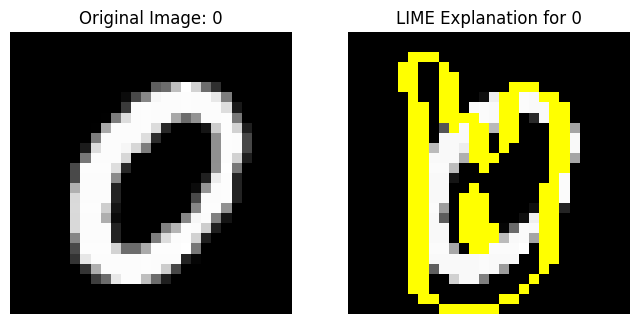

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


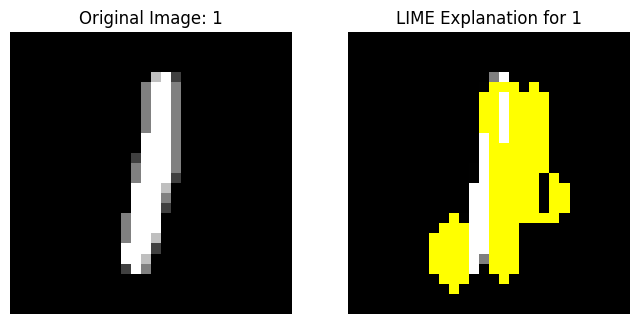

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


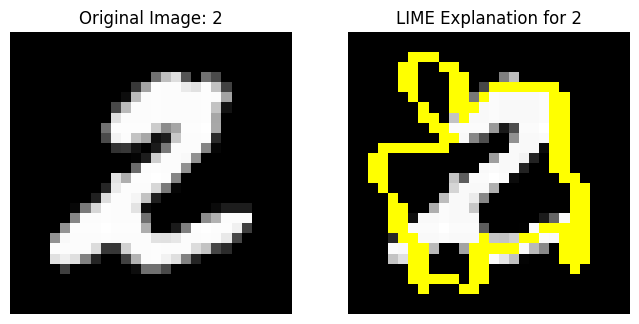

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


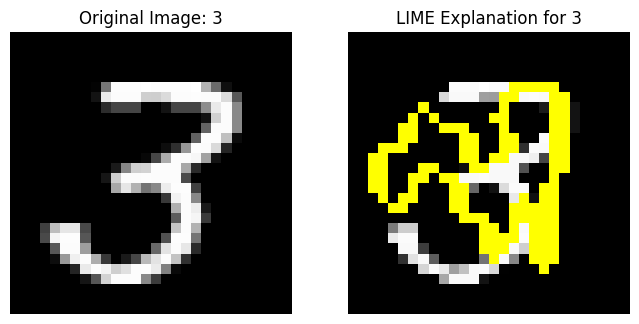

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


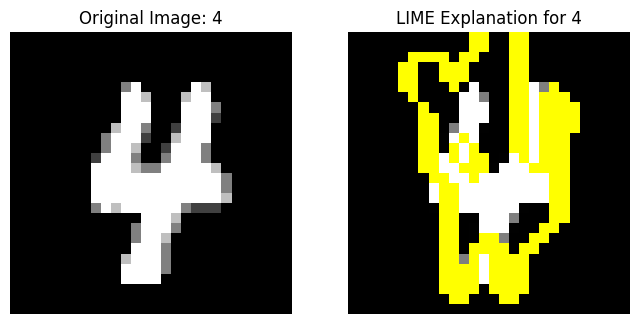

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


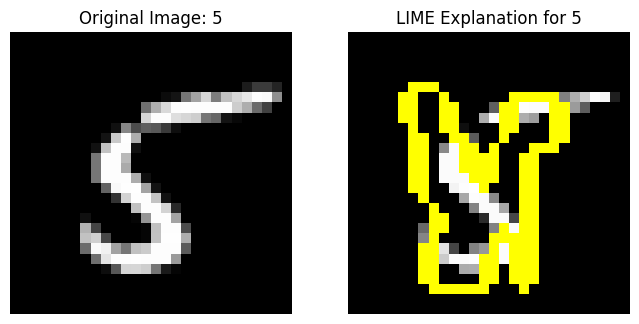

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


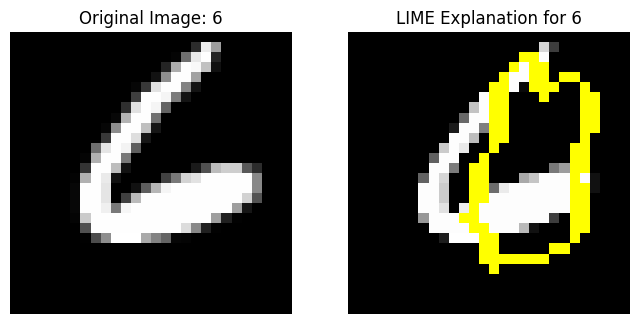

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


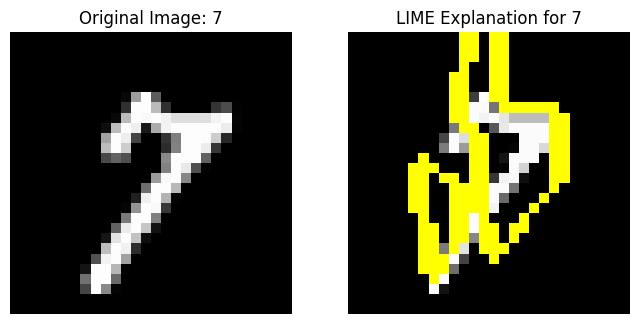

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


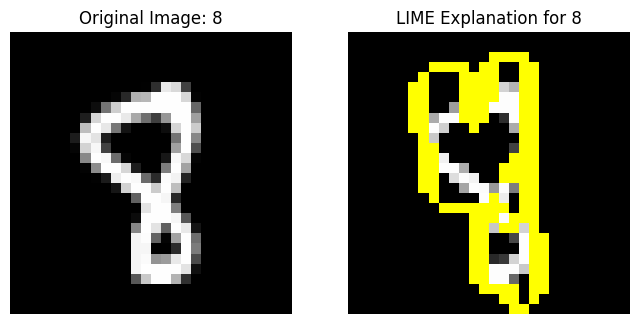

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


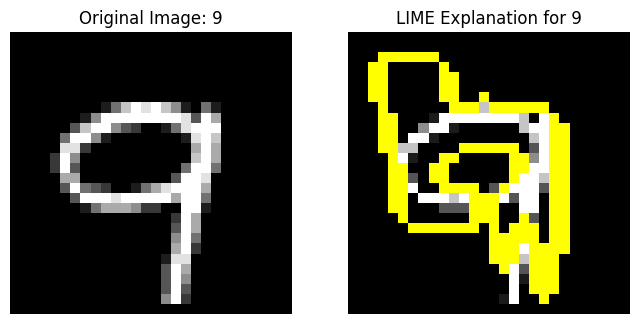

In [7]:
# Initialize a dictionary to store one image for each digit
digit_examples = {}

# Iterate over the test data loader to collect one example for each digit
for images, labels in test_dl:
    labels_list = labels.tolist()
    for i, label in enumerate(labels_list):
        if label not in digit_examples:
            # Detach the image tensor and convert to numpy array
            digit_examples[label] = images[i].detach().numpy()
            
        # If we've collected all digits, break out of loop
        if len(digit_examples) == 10:
            break
            
    # If we've collected all digits, break out of loop
    if len(digit_examples) == 10:
        break

# Create a SegmentationAlgorithm object with 'slic' algorithm
segmentation_fn = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

# Now iterate through each digit and explain using LIME
for digit in range(10):
    # Retrieve the selected image of the digit from the dictionary
    image = np.squeeze(digit_examples[digit])

    # Get explanation from LIME
    explanation = explainer.explain_instance(image, 
                                             cnn.predict, 
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000,
                                             segmentation_fn=segmentation_fn)
  
    # Get image and mask for the explanation of the digit
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, 
                                                num_features=5, 
                                                hide_rest=False)
    
    # Plot the image and the explanation
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original Image: {digit}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for {digit}')
    plt.axis('off')

    plt.show()

Let's try to answer the question: "Are there any specific patterns discriminating certain digits?"

The yellow portion of the images in the LIME output represent the "explanation" of what parts of the image were most influential in the model's decision to classify the digits. 

General Patterns Across All Digits

- Loops and Curves: For digits like "0," "6," and "8," the model appears to focus on the loops or curves. These are features that are not present in other digits and are therefore strong discriminative features.
- Straight Lines and Angles: For digits like "1," "4," and "7," the model pays attention to straight lines and angles. These are unique features for these digits and help distinguish them from others.
- Endpoints and Joints: For digits like "2," "3," and "5," the model seems to concentrate on the endpoints and joints where curves meet straight lines. This helps in distinguishing these digits from others that either have simple curves or straight lines.
- Unique Shapes: For digits like "9," the model focuses on both the loop and the straight line, capturing its unique shape.
- Color Intensity: The color intensity in the highlighted regions varies across digits. Brighter regions may indicate a stronger influence on the model's decision for that specific digit.